# '정확한' 설명자

이 노트북은 몇 가지 간단한 데이터 집합에서 정확한 설명자를 사용하는 방법을 보여드립니다. Exact 설명자는 모델에 구애받지 않으므로 어떤 모델에 대해서도 근사치 없이 샤플리 값과 오웬 값을 정확히 계산할 수 있습니다. 하지만 마스킹 패턴의 공간을 완전히 열거하기 때문에 M 입력 특징에 대한 균형 클러스터링 트리에서 샤플리 값의 경우 $O(2^M)$ 복잡성, 오웬 값의 경우 $O(M^2)$ 복잡성을 갖습니다.

정확한 설명자는 마스킹 공간을 완전히 열거하고 있다는 것을 알고 있기 때문에 [회색 코드](https://en.wikipedia.org/wiki/Gray_code) 순서를 사용하여 연속적인 마스킹 패턴 간에 변경되는 입력 수를 최소화하는 등 무작위 샘플링 기반 접근 방식에서는 불가능한 최적화를 사용할 수 있으므로 모델을 호출해야 하는 횟수를 잠재적으로 줄일 수 있습니다.

In [1]:
import shap
import xgboost

# 소득 예측에 대한 데이터 세트 가져오기
X,y = shap.datasets.adult()

# XGBoost 모델을 훈련합니다(다른 모델 유형도 작동 가능).
model = xgboost.XGBClassifier()
model.fit(X, y);

## 독립(샤플리 값) 마스킹이 적용된 테이블 형식 데이터

In [4]:
# 정확한 설명자를 작성하고 주어진 데이터 세트에 대한 모델 예측을 설명합니다.
explainer = shap.explainers.Exact(model.predict_proba, X)
shap_values = explainer(X[:100])

# 긍정적 클래스만 설명받기
shap_values = shap_values[...,1]

### 글로벌 요약 플롯

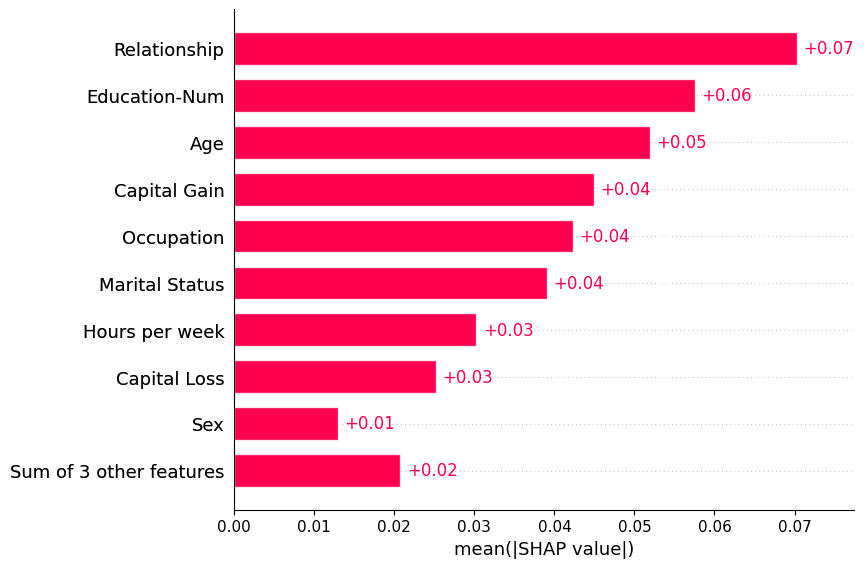

In [5]:
shap.plots.bar(shap_values)

### 단일 인스턴스 플롯

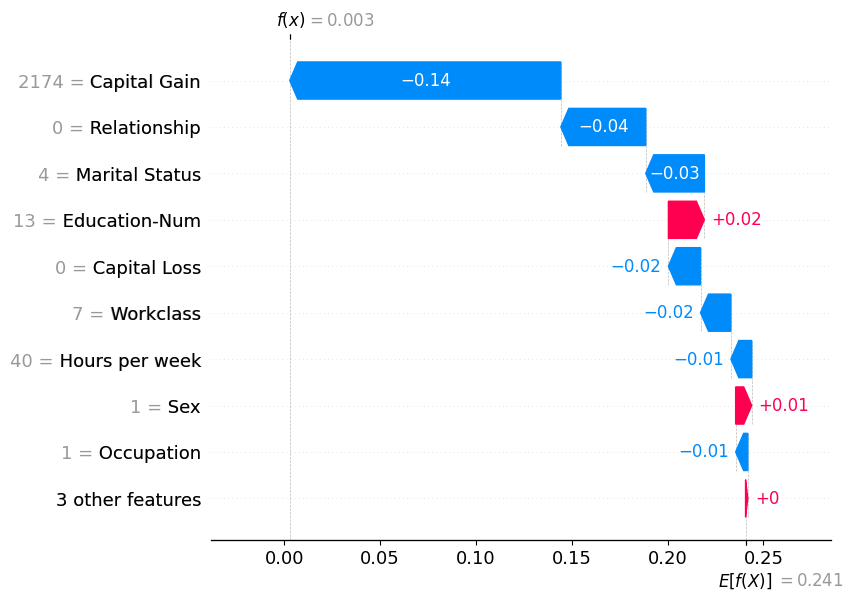

In [6]:
shap.plots.waterfall(shap_values[0])

##  파티션(오웬 값) 마스킹이 있는 테이블형 데이터

샤플리 값은 각 특징을 다른 특징과 독립적으로 처리한 결과이지만, 모델 입력에 구조를 적용하는 것이 유용할 때가 많습니다. 이러한 구조를 적용하면 구조 게임(즉, 유효한 입력 특징 연합에 대한 규칙이 있는 게임)이 생성되며, 해당 구조가 특징 그룹화의 중첩 집합인 경우 그룹에 샤플리 값을 재귀적으로 적용하여 오웬 값을 얻게 됩니다. SHAP에서는 파티셔닝을 한계까지 확장하여 데이터의 구조를 나타내는 이진 계층적 클러스터링 트리를 구축합니다. 이 구조는 여러 가지 방법으로 선택할 수 있지만, 표 형식 데이터의 경우 출력 레이블에 대한 입력 특징 간의 중복 정보로부터 구조를 구축하는 것이 도움이 되는 경우가 많습니다. 이것이 바로 아래에서 수행하는 작업입니다:

In [7]:
# y 에 대한 공유 정보를 기반으로 특징의 클러스터링을 구축합니다.
clustering = shap.utils.hclust(X, y)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [8]:
# 위에서는 원시 데이터 프레임을 마스커로 전달하여 암시적으로 shap.maskers.Independent를 사용했습니다
# 이제 방금 계산한 클러스터링을 사용하는 Partition 마스커를 명시적으로 사용합니다.
masker = shap.maskers.Partition(X, clustering=clustering)

# 정확한 설명자를 작성하고 주어진 데이터 세트에 대한 모델 예측을 설명합니다.
explainer = shap.explainers.Exact(model.predict_proba, masker)
shap_values2 = explainer(X[:100])

# 긍정적 인 클래스에 대한 설명 만 얻으십시오.
shap_values2 = shap_values2[...,1]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### 전역 요약 플롯

관계 및 결혼 상태 특징만 서로 50% 이상의 설명력(R2로 측정)을 공유하므로 클러스터링 트리의 다른 모든 부분은 기본 `클러스터링_컷오프=0.5` 설정에 의해 제거됩니다:

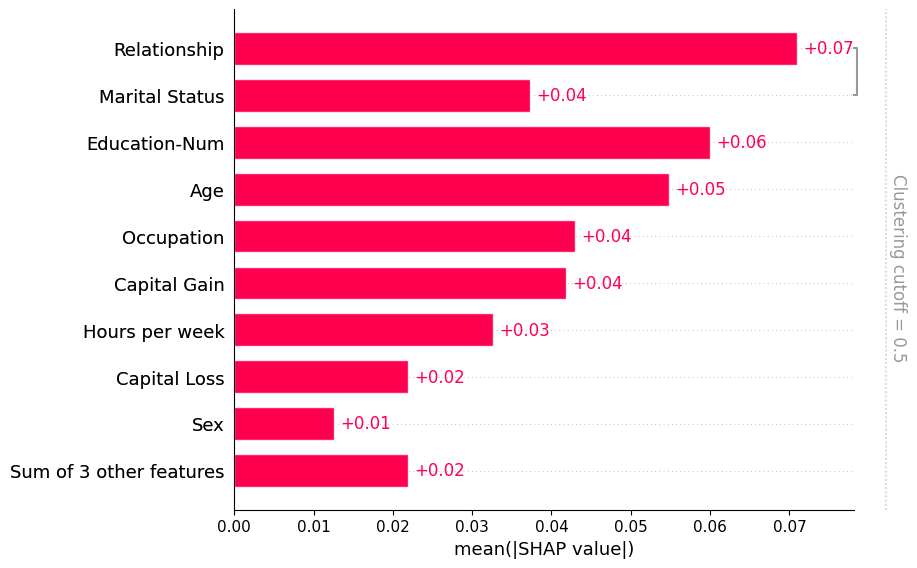

In [10]:
shap.plots.bar(shap_values2)

### 단일 인스턴스 플롯

위의 독립 마스커 설명과 여기서의 파티션 마스커 설명 사이에는 매우 유사하다는 점에 유의하십시오. 일반적으로 표 형식 데이터에 대한 이 두 방법의 차이는 크지 않지만, 파티션 마스커를 사용하면 클러스터된 특징 그룹이 함께 마스킹/마스킹 해제되므로 런타임이 훨씬 빠르고 모델 입력을 보다 사실적으로 조작할 수 있습니다.

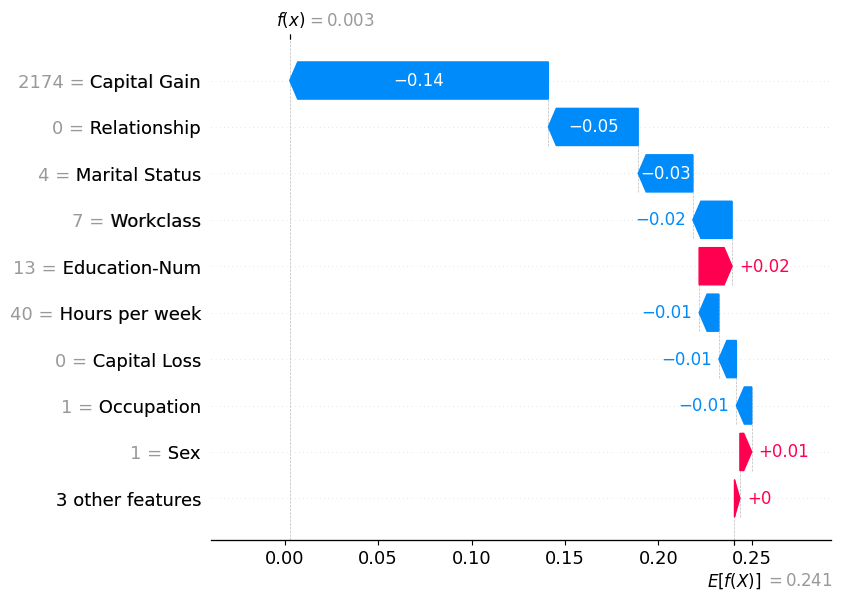

In [11]:
shap.plots.waterfall(shap_values2[0])